In [1]:
!pip install timm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import math
import time
import copy
import os
import os.path
import numpy as np
import torch
import torch.nn as  nn
import torch.nn.functional as F
from pandas import read_csv
from torch.utils.data import Dataset, TensorDataset, DataLoader
import torchvision.transforms as transforms
from timm.models.layers import DropPath, to_2tuple, trunc_normal_

In [3]:
# device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 데이터셋 준비

In [100]:
df = read_csv('stockdata.csv')
data = df.values
data = data.T
data = np.array(data)
data

array([[13750., 14050., 14100., ..., 12400., 12350., 12250.],
       [13750., 13750., 14050., ..., 12200., 12450., 12300.],
       [13800., 14050., 14100., ..., 12500., 12450., 12350.],
       ...,
       [10400., 10800., 10450., ...,  4150.,  4095.,  4295.],
       [10900., 10800., 10450., ...,  4270.,  4265.,  4315.],
       [10250., 10350., 10050., ...,  4095.,  4085.,  4130.]])

In [101]:
data.shape

(12944, 121)

In [102]:
data = np.nan_to_num(data, nan = 0)

In [103]:
data = (data - data.mean(-1, keepdims = True)) / (data.var(-1, keepdims = True) + 1e-10) ** -0.5

In [99]:
data_ = []
nans = []
for i in range(data.shape[0]):
    if not np.isnan(data[i]).any():
        data_.append(data[i])
    else:
        nans.append(data[i])

nans = np.array(nans)
print(nans.shape)
data = np.array(data_)
print(data.shape)

(0,)
(12944, 121)


In [82]:
'''
data_ = []
nans = []
for i in range(data.shape[0]):
    if not np.isnan(data[i]).any():
        data_.append(data[i])
    else:
        nans.append(data[i])

nans = np.array(nans)
print(nans.shape)
data = np.array(data_)
print(data.shape)
'''

'\ndata_ = []\nnans = []\nfor i in range(data.shape[0]):\n    if not np.isnan(data[i]).any():\n        data_.append(data[i])\n    else:\n        nans.append(data[i])\n\nnans = np.array(nans)\nprint(nans.shape)\ndata = np.array(data_)\nprint(data.shape)\n'

In [104]:
# 종가
data_close_price=[data[0]]
for i in range(2,3237):
  arr = np.array(data[4*(i-1)])
  data_close_price = np.append(data_close_price, [arr], axis=0)


data_close_price

array([[-1.05983898e+06, -7.33527232e+05, -6.79141941e+05, ...,
        -2.52824184e+06, -2.58262713e+06, -2.69139771e+06],
       [ 3.21131208e+06,  3.14775815e+06,  2.70288060e+06, ...,
        -3.30932171e+06, -3.28390013e+06, -3.47456194e+06],
       [ 4.83994006e+03,  6.41698645e+03,  7.65119667e+03, ...,
        -1.20275996e+04, -1.20961668e+04, -1.27818391e+04],
       ...,
       [ 1.92302565e+06,  2.04638008e+06,  1.87015946e+06, ...,
        -8.52449012e+05, -8.78882104e+05, -1.09034684e+06],
       [ 1.50119245e+07,  1.42064066e+07,  1.27296238e+07, ...,
        -1.15701662e+07, -1.23756841e+07, -1.14359132e+07],
       [ 5.62559419e+06,  5.05799202e+06,  4.56134013e+06, ...,
        -3.82498187e+06, -3.76822165e+06, -3.83917192e+06]])

In [105]:
# 시가
data_open=[data[1]]
for i in range(2,3237):
  arr = np.array(data[4*(i-1)+1])
  data_open = np.append(data_open, [arr], axis=0)


data_open

array([[-1.05598434e+06, -1.05598434e+06, -7.31547342e+05, ...,
        -2.73224218e+06, -2.46187801e+06, -2.62409651e+06],
       [ 3.04726442e+06,  3.30574251e+06,  3.17650346e+06, ...,
        -3.58269858e+06, -3.60854639e+06, -3.42761172e+06],
       [ 3.86592295e+03,  4.13398982e+03,  6.14449129e+03, ...,
        -1.21510722e+04, -1.20170387e+04, -1.20840554e+04],
       ...,
       [ 1.94179992e+06,  1.93281182e+06,  1.95977611e+06, ...,
        -9.34390465e+05, -9.52366655e+05, -9.07426180e+05],
       [ 1.39387371e+07,  1.42064706e+07,  1.42064706e+07, ...,
        -1.10943452e+07, -1.21652792e+07, -1.18975457e+07],
       [ 4.97228283e+06,  5.54241499e+06,  5.04354935e+06, ...,
        -3.93603227e+06, -4.01442545e+06, -3.72935936e+06]])

In [106]:
# 고가
data_high=[data[2]]
for i in range(2,3237):
  arr = np.array(data[4*(i-1)+2])
  data_high = np.append(data_high, [arr], axis=0)


data_high

array([[-1.26304429e+06, -9.99274253e+05, -9.46520246e+05, ...,
        -2.63464848e+06, -2.68740249e+06, -2.79291050e+06],
       [ 3.01079352e+06,  3.01079352e+06,  2.88159783e+06, ...,
        -3.68154340e+06, -3.61694555e+06, -3.60402598e+06],
       [ 4.04972208e+03,  5.52715838e+03,  6.93424056e+03, ...,
        -1.27649101e+04, -1.35388053e+04, -1.32573888e+04],
       ...,
       [ 1.79144009e+06,  1.93180304e+06,  1.87039425e+06, ...,
        -9.54410029e+05, -8.31592452e+05, -9.28091977e+05],
       [ 1.51699952e+07,  1.44592505e+07,  1.36063568e+07, ...,
        -1.32597953e+07, -1.38283911e+07, -1.21226036e+07],
       [ 5.53300752e+06,  5.38847240e+06,  4.88259947e+06, ...,
        -4.04967104e+06, -4.05689780e+06, -3.98463024e+06]])

In [107]:
# 저가
data_low=[data[3]]
for i in range(2,3237):
  arr = np.array(data[4*(i-1)+3])
  data_low = np.append(data_low, [arr], axis=0)


data_low

array([[-9.77303054e+05, -8.66940320e+05, -5.91033485e+05, ...,
        -2.57756270e+06, -2.57756270e+06, -2.96383227e+06],
       [ 2.98372058e+06,  3.17401022e+06,  2.85686082e+06, ...,
        -3.39732534e+06, -3.29583753e+06, -3.25777960e+06],
       [ 5.04902411e+03,  5.18677652e+03,  6.97755778e+03, ...,
        -1.18945217e+04, -1.29276648e+04, -1.21700265e+04],
       ...,
       [ 1.95321987e+06,  1.95321987e+06,  2.00758623e+06, ...,
        -9.73502218e+05, -8.91952686e+05, -1.05505175e+06],
       [ 1.43052053e+07,  1.47005151e+07,  1.32510459e+07, ...,
        -1.05993121e+07, -1.11263918e+07, -1.08628519e+07],
       [ 4.89461719e+06,  5.03371780e+06,  4.61641596e+06, ...,
        -3.66702554e+06, -3.68093560e+06, -3.61834032e+06]])

In [108]:
data_close_price = torch.from_numpy(data_close_price)

data_open = torch.from_numpy(data_open)

data_high = torch.from_numpy(data_high)

data_low = torch.from_numpy(data_low)

In [109]:
class MyBaseDataset(Dataset):
    def __init__(self, x_data, y_data):
        self.x_data = x_data
        self.y_data = y_data
        
    def __getitem__(self, index): 
        return self.x_data[index], self.y_data[index]
        
    def __len__(self): 
        return self.x_data.shape[0]

In [110]:
train_data_CO = TensorDataset(data_close_price,data_open)
train_data_CH = TensorDataset(data_close_price,data_high)
train_data_CL = TensorDataset(data_close_price,data_low)
train_data_OH = TensorDataset(data_open,data_high)
train_data_OL = TensorDataset(data_open,data_low)
train_data_HL = TensorDataset(data_high,data_low)

In [112]:
BATCH_SIZE = 32

train_loader_CO = DataLoader(train_data_CO, batch_size=BATCH_SIZE, shuffle=True)

train_loader_CH = DataLoader(train_data_CH, batch_size=BATCH_SIZE, shuffle=True)

train_loader_CL = DataLoader(train_data_CL, batch_size=BATCH_SIZE, shuffle=True)

train_loader_OH = DataLoader(train_data_OH, batch_size=BATCH_SIZE, shuffle=True)

train_loader_OL = DataLoader(train_data_OL, batch_size=BATCH_SIZE, shuffle=True)

train_loader_HL = DataLoader(train_data_HL, batch_size=BATCH_SIZE, shuffle=True)

# 모델 정의

In [16]:
class ConvEmbedding(nn.Module):
    def __init__(self, 
                 patch_size = 5,
                 stride = 1,
                 in_chans = 1,
                 embed_dim = 64):
        super().__init__()

        self.conv = nn.Conv1d(in_chans, embed_dim,
                              kernel_size = patch_size, 
                              stride = stride, padding = patch_size // 2)
        
        self.norm = nn.LayerNorm(embed_dim)
    
    def forward(self, x):
        # x, shape of (Batch_size, in_channels, seq_length)
        x = self.conv(x)
        x = x.transpose(-2, -1)
        x = self.norm(x)

        return x

In [17]:
class Attention(nn.Module):
    def __init__(self, 
                 dim,
                 num_heads = 8,
                 qkv_bias = False,
                 qk_scale = None,
                 attn_drop = 0.,
                 proj_drop = 0.,):
        super().__init__()

        self.num_heads = num_heads
        head_dim = dim // num_heads
        self.scale = qk_scale or  head_dim ** -.5

        self.qkv = nn.Linear(dim, dim * 3, bias = qkv_bias)
        self.attn_drop = nn.Dropout(attn_drop)
        self.proj = nn.Linear(dim, dim)
        self.proj_drop = nn.Dropout(proj_drop)

    def forward(self, x):
        B, N, C = x.shape

        qkv = self.qkv(x).reshape(B, N, 3, self.num_heads, C // self.num_heads).permute(2, 0, 3, 1, 4)
        q, k, v = qkv[0], qkv[1], qkv[2]

        attn = (q @ k.transpose(-2, -1)) * self.scale
        attn = attn.softmax(dim = -1)
        attn = self.attn_drop(attn)

        x = (attn @ v).transpose(1, 2).reshape(B, N, -1)
        x = self.proj(x)
        x = self.proj_drop(x)
        return x

In [18]:
class Mlp(nn.Module):
    def __init__(self, 
                 in_features,
                 hidden_features = None,
                 out_features = None,
                 act_layer = nn.ReLU,
                 drop = 0.):
        super().__init__()

        out_features = out_features or in_features
        hidden_features = hidden_features or in_features

        self.fc1 = nn.Linear(in_features, hidden_features)
        self.act = act_layer()
        self.fc2 = nn.Linear(hidden_features, out_features)
        self.drop = nn.Dropout(drop)

    def forward(self, x):
        x = self.fc1(x)
        x = self.act(x)
        x = self.drop(x)
        x = self.fc2(x)
        x = self.drop(x)
        return x

In [19]:
class Block(nn.Module):
    def __init__(self, 
                 dim,
                 num_heads,
                 mlp_ratio = 4.,
                 qkv_bias = False,
                 drop = 0.,
                 drop_path = 0.,
                 attn_drop = 0.,
                 act_layer = nn.ReLU,
                 norm_layer = nn.LayerNorm,
                 ):
        super().__init__()

        self.norm1 = norm_layer(dim)
        self.MSA = Attention(dim, num_heads, qkv_bias, attn_drop = attn_drop, proj_drop = drop)

        self.drop_path = DropPath(drop_path) if drop_path > 0 else nn.Identity()

        self.norm2 = norm_layer(dim)
        self.FFN = Mlp(dim, int(mlp_ratio * dim), act_layer = act_layer, drop = drop)

    def forward(self, x):
        x = x + self.drop_path(self.MSA(self.norm1(x)))
        x = x + self.drop_path(self.FFN(self.norm2(x)))

        return x

In [20]:
class Time_Series_Encoder(nn.Module):
    def __init__(self,
                 patch_size = 5,
                 in_chans = 1,
                 embed_dims = [64, 128, 256],
                 strides = [1, 2, 2],
                 num_heads = [2, 4, 8],
                 mlp_ratio = 4.,
                 qkv_bias = False,
                 drop_rate = 0.1,
                 attn_drop_rate = 0.,
                 drop_path_rate = 0.1, 
                 depths = [2, 9, 1],
                 num_stages = 3,
                 act_layer = nn.ReLU,
                 norm_layer = nn.LayerNorm,):
        super().__init__()

        self.depths = depths
        self.num_stages = num_stages

        dpr = [x.item() for x in torch.linspace(0, drop_path_rate, sum(depths))] # stochastic depth decay
        cur = 0

        for i in range(num_stages):
            patch_embed = ConvEmbedding(patch_size = patch_size if i == 0 else 3,
                                        stride = strides[i],
                                        in_chans = 1 if i == 0 else embed_dims[i - 1],
                                        embed_dim = embed_dims[i])
            blocks = nn.ModuleList([
                                    Block(embed_dims[i], num_heads = num_heads[i], 
                                          mlp_ratio = mlp_ratio, qkv_bias = qkv_bias,
                                          drop = drop_rate, drop_path = dpr[cur + j], 
                                          attn_drop = attn_drop_rate, act_layer = act_layer,
                                          norm_layer = norm_layer) for j in range(depths[i])
            ])
            norm = norm_layer(embed_dims[i])
            cur += depths[i]

            setattr(self, f"patch_embed{i + 1}", patch_embed)
            setattr(self, f"blocks{i + 1}", blocks)
            setattr(self, f"norm{i + 1}", norm)
        
        self.apply(self._init_weights)

    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            trunc_normal_(m.weight, std = .02)
            if isinstance(m, nn.Linear) and m.bias is not None:
                nn.init.constant_(m.bias, 0.)
        elif isinstance(m, nn.LayerNorm):
            nn.init.constant_(m.bias, 0)
            nn.init.constant_(m.weight, 1.0)
    
    def forward(self, x):
        B = x.shape[0]

        for i in range(self.num_stages):
            patch_embed = getattr(self, f"patch_embed{i + 1}")
            blocks = getattr(self, f"blocks{i + 1}")
            norm = getattr(self, f"norm{i + 1}")

            x = patch_embed(x)
            for block in blocks:
                x = block(x)
            x = norm(x)

            if i != self.num_stages - 1:
                x = x.transpose(-2, -1).contiguous()
        
        return x.mean(dim = 1)

In [21]:
model = Time_Series_Encoder().to(device)

In [22]:
def count_parameters(model):
    params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    return params / 1000000

print(count_parameters(model))


2.795008


In [23]:
def test():
    input = torch.rand(256, 1, 121).to(device)
    output = model(input)
    print(output.size())

In [24]:
test()

torch.Size([256, 256])


In [25]:
def cross_entropy(preds, targets, reduction='none'):
    log_softmax = nn.LogSoftmax(dim=-1)
    loss = (-targets * log_softmax(preds)).sum(1)
    if reduction == "none":
        return loss
    elif reduction == "mean":
        return loss.mean()

In [113]:
class CSM(nn.Module):
    def __init__(self,
                 temperature = 1.,
                 embed_dim = 32):
        super().__init__()

        self.seq_encoder = Time_Series_Encoder().to(device)
        self.seq_projection = nn.Sequential(
            nn.Linear(256, embed_dim),
            nn.GELU(),
            nn.LayerNorm(embed_dim),
        )
        self.temperature = temperature

    def forward(self, source, target):
        s_features = self.seq_encoder(source)
        t_features = self.seq_encoder(target)

        # Getting source and target sequence embeddings (with same dimension)
        s_embeddings = self.seq_projection(s_features)
        t_embeddings = self.seq_projection(t_features)

        # Calculating the loss
        logits = (s_embeddings @ t_embeddings.T + 1e-20) / self.temperature
        s_sim = s_embeddings @ s_embeddings.T
        t_sim = t_embeddings @ t_embeddings.T
        labels = F.softmax(
            (s_sim + t_sim ) / 2 * self.temperature, dim = -1
        )
        target_loss = cross_entropy(logits, labels, reduction = 'none')
        source_loss = cross_entropy(logits.T, labels.T, reduction = 'none')
        loss = (source_loss + target_loss) / 2.0 # shape : (batch_size, )

        return loss.mean(), logits


# 학습하기

In [114]:
# training utilities
import torch.optim as optim
from tqdm import tqdm


class AvgMeter:
    def __init__(self, name="Metric"):
        self.name = name
        self.reset()

    def reset(self):
        self.avg, self.sum, self.count = [0] * 3

    def update(self, val, count=1):
        self.count += count
        self.sum += val * count
        self.avg = self.sum / self.count

    def __repr__(self):
        text = f"{self.name}: {self.avg:.4f}"
        return text

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group["lr"]

In [115]:
def train_epoch(model, train_loader, optimizer, lr_scheduler, step):
    loss_meter = AvgMeter()
    tqdm_object = tqdm(train_loader, total=len(train_loader))
    for source, target in tqdm_object:
        source, target = source.float().unsqueeze(1).to(device), target.float().unsqueeze(1).to(device)
        loss, _ = model(source, target)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if step == "batch":
            lr_scheduler.step()

        count = source.size(0)
        loss_meter.update(loss.item(), count)

        tqdm_object.set_postfix(train_loss=loss_meter.avg, lr=get_lr(optimizer))
    return loss_meter


def valid_epoch(model, valid_loader):
    loss_meter = AvgMeter()

    tqdm_object = tqdm(valid_loader, total=len(valid_loader))
    for source, target in tqdm_object:
        source, target = source.float().unsqueeze(1).to(device), target.float().unsqueeze(1).to(device)
        loss, _ = model(source, target)

        count = source.size(0)
        loss_meter.update(loss.item(), count)

        tqdm_object.set_postfix(valid_loss=loss_meter.avg)
    return loss_meter

In [116]:
model = CSM().to(device)

In [117]:
params = [
        {"params": model.seq_encoder.parameters(), "lr": 1e-4},
        {"params": model.seq_projection.parameters(), 
         "lr": 1e-4, "weight_decay": 0.05}
    ]

optimizer = torch.optim.AdamW(params, weight_decay = 0.)
lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode = 'min', patience = 5, factor = 0.8
)
step = 'eppch'
num_epochs = 100

In [118]:
best_loss = float('inf')
for epoch in range(num_epochs):
    print(f"Epoch: {epoch + 1}")
    model.train()
    train_loss = train_epoch(model, train_loader_CH, optimizer, lr_scheduler, step)
    model.eval()
    with torch.no_grad():
        val_loss = valid_epoch(model, train_loader_CO)
    
    if val_loss.avg < best_loss:
        best_loss = val_loss.avg
        torch.save(model.state_dict(), "best_CSM.pt")
        print("Saved Best Model!")
    
    lr_scheduler.step(val_loss.avg)

Epoch: 1


100%|██████████| 102/102 [00:01<00:00, 65.57it/s, valid_loss=0.802]


Saved Best Model!
Epoch: 2


100%|██████████| 102/102 [00:01<00:00, 65.67it/s, valid_loss=0.712]


Saved Best Model!
Epoch: 3


100%|██████████| 102/102 [00:01<00:00, 64.98it/s, valid_loss=0.545]


Saved Best Model!
Epoch: 4


100%|██████████| 102/102 [00:01<00:00, 64.65it/s, valid_loss=0.434]


Saved Best Model!
Epoch: 5


100%|██████████| 102/102 [00:01<00:00, 65.28it/s, valid_loss=0.34]


Saved Best Model!
Epoch: 6


100%|██████████| 102/102 [00:01<00:00, 65.71it/s, valid_loss=0.384]


Epoch: 7


100%|██████████| 102/102 [00:01<00:00, 65.87it/s, valid_loss=0.301]


Saved Best Model!
Epoch: 8


100%|██████████| 102/102 [00:01<00:00, 64.72it/s, valid_loss=0.269]


Saved Best Model!
Epoch: 9


100%|██████████| 102/102 [00:01<00:00, 65.06it/s, valid_loss=0.257]


Saved Best Model!
Epoch: 10


100%|██████████| 102/102 [00:01<00:00, 65.77it/s, valid_loss=0.24]


Saved Best Model!
Epoch: 11


100%|██████████| 102/102 [00:01<00:00, 65.40it/s, valid_loss=0.264]


Epoch: 12


100%|██████████| 102/102 [00:01<00:00, 66.25it/s, valid_loss=0.276]


Epoch: 13


100%|██████████| 102/102 [00:01<00:00, 65.62it/s, valid_loss=0.309]


Epoch: 14


100%|██████████| 102/102 [00:01<00:00, 65.13it/s, valid_loss=0.23]


Saved Best Model!
Epoch: 15


100%|██████████| 102/102 [00:01<00:00, 64.88it/s, valid_loss=0.236]


Epoch: 16


100%|██████████| 102/102 [00:01<00:00, 65.62it/s, valid_loss=0.228]


Saved Best Model!
Epoch: 17


100%|██████████| 102/102 [00:01<00:00, 65.18it/s, valid_loss=0.222]


Saved Best Model!
Epoch: 18


100%|██████████| 102/102 [00:01<00:00, 65.69it/s, valid_loss=0.246]


Epoch: 19


100%|██████████| 102/102 [00:01<00:00, 65.21it/s, valid_loss=0.305]


Epoch: 20


100%|██████████| 102/102 [00:01<00:00, 65.80it/s, valid_loss=0.243]


Epoch: 21


100%|██████████| 102/102 [00:01<00:00, 65.69it/s, valid_loss=0.248]


Epoch: 22


100%|██████████| 102/102 [00:01<00:00, 65.30it/s, valid_loss=0.252]


Epoch: 23


100%|██████████| 102/102 [00:01<00:00, 64.47it/s, valid_loss=0.234]


Epoch: 24


100%|██████████| 102/102 [00:01<00:00, 65.61it/s, valid_loss=0.208]


Saved Best Model!
Epoch: 25


100%|██████████| 102/102 [00:01<00:00, 64.46it/s, valid_loss=0.226]


Epoch: 26


100%|██████████| 102/102 [00:01<00:00, 65.00it/s, valid_loss=0.224]


Epoch: 27


100%|██████████| 102/102 [00:01<00:00, 64.66it/s, valid_loss=0.245]


Epoch: 28


100%|██████████| 102/102 [00:01<00:00, 65.67it/s, valid_loss=0.252]


Epoch: 29


100%|██████████| 102/102 [00:01<00:00, 65.44it/s, valid_loss=0.193]


Saved Best Model!
Epoch: 30


100%|██████████| 102/102 [00:01<00:00, 61.39it/s, valid_loss=0.194]


Epoch: 31


100%|██████████| 102/102 [00:01<00:00, 64.13it/s, valid_loss=0.215]


Epoch: 32


100%|██████████| 102/102 [00:01<00:00, 65.52it/s, valid_loss=0.182]


Saved Best Model!
Epoch: 33


100%|██████████| 102/102 [00:01<00:00, 65.07it/s, valid_loss=0.227]


Epoch: 34


100%|██████████| 102/102 [00:01<00:00, 65.22it/s, valid_loss=0.251]


Epoch: 35


100%|██████████| 102/102 [00:01<00:00, 64.79it/s, valid_loss=0.26]


Epoch: 36


100%|██████████| 102/102 [00:01<00:00, 65.19it/s, valid_loss=0.24]


Epoch: 37


100%|██████████| 102/102 [00:01<00:00, 65.63it/s, valid_loss=0.21]


Epoch: 38


100%|██████████| 102/102 [00:01<00:00, 65.26it/s, valid_loss=0.226]


Epoch: 39


100%|██████████| 102/102 [00:01<00:00, 65.29it/s, valid_loss=0.246]


Epoch: 40


100%|██████████| 102/102 [00:01<00:00, 65.65it/s, valid_loss=0.208]


Epoch: 41


100%|██████████| 102/102 [00:01<00:00, 64.92it/s, valid_loss=0.204]


Epoch: 42


100%|██████████| 102/102 [00:01<00:00, 65.70it/s, valid_loss=0.226]


Epoch: 43


100%|██████████| 102/102 [00:01<00:00, 64.94it/s, valid_loss=0.201]


Epoch: 44


100%|██████████| 102/102 [00:01<00:00, 65.42it/s, valid_loss=0.194]


Epoch: 45


100%|██████████| 102/102 [00:01<00:00, 64.74it/s, valid_loss=0.283]


Epoch: 46


100%|██████████| 102/102 [00:01<00:00, 64.25it/s, valid_loss=0.2]


Epoch: 47


100%|██████████| 102/102 [00:01<00:00, 64.49it/s, valid_loss=0.183]


Epoch: 48


100%|██████████| 102/102 [00:01<00:00, 65.33it/s, valid_loss=0.19]


Epoch: 49


100%|██████████| 102/102 [00:01<00:00, 64.48it/s, valid_loss=0.181]


Saved Best Model!
Epoch: 50


100%|██████████| 102/102 [00:01<00:00, 64.55it/s, valid_loss=0.199]


Epoch: 51


100%|██████████| 102/102 [00:01<00:00, 64.98it/s, valid_loss=0.257]


Epoch: 52


100%|██████████| 102/102 [00:01<00:00, 65.29it/s, valid_loss=0.257]


Epoch: 53


100%|██████████| 102/102 [00:01<00:00, 64.50it/s, valid_loss=0.312]


Epoch: 54


100%|██████████| 102/102 [00:01<00:00, 65.36it/s, valid_loss=0.212]


Epoch: 55


100%|██████████| 102/102 [00:01<00:00, 64.57it/s, valid_loss=0.22]


Epoch: 56


100%|██████████| 102/102 [00:01<00:00, 65.56it/s, valid_loss=0.226]


Epoch: 57


100%|██████████| 102/102 [00:01<00:00, 64.22it/s, valid_loss=0.22]


Epoch: 58


100%|██████████| 102/102 [00:01<00:00, 64.84it/s, valid_loss=0.172]


Saved Best Model!
Epoch: 59


100%|██████████| 102/102 [00:01<00:00, 64.46it/s, valid_loss=0.192]


Epoch: 60


100%|██████████| 102/102 [00:01<00:00, 65.10it/s, valid_loss=0.177]


Epoch: 61


100%|██████████| 102/102 [00:01<00:00, 65.28it/s, valid_loss=0.198]


Epoch: 62


100%|██████████| 102/102 [00:01<00:00, 65.07it/s, valid_loss=0.219]


Epoch: 63


100%|██████████| 102/102 [00:01<00:00, 65.14it/s, valid_loss=0.182]


Epoch: 64


100%|██████████| 102/102 [00:01<00:00, 64.69it/s, valid_loss=0.168]


Saved Best Model!
Epoch: 65


100%|██████████| 102/102 [00:01<00:00, 65.11it/s, valid_loss=0.191]


Epoch: 66


100%|██████████| 102/102 [00:01<00:00, 64.68it/s, valid_loss=0.224]


Epoch: 67


100%|██████████| 102/102 [00:01<00:00, 65.10it/s, valid_loss=0.214]


Epoch: 68


100%|██████████| 102/102 [00:01<00:00, 63.81it/s, valid_loss=0.227]


Epoch: 69


100%|██████████| 102/102 [00:01<00:00, 65.15it/s, valid_loss=0.223]


Epoch: 70


100%|██████████| 102/102 [00:01<00:00, 65.47it/s, valid_loss=0.183]


Epoch: 71


100%|██████████| 102/102 [00:01<00:00, 64.60it/s, valid_loss=0.193]


Epoch: 72


100%|██████████| 102/102 [00:01<00:00, 64.66it/s, valid_loss=0.212]


Epoch: 73


100%|██████████| 102/102 [00:01<00:00, 64.44it/s, valid_loss=0.189]


Epoch: 74


100%|██████████| 102/102 [00:01<00:00, 65.11it/s, valid_loss=0.19]


Epoch: 75


100%|██████████| 102/102 [00:01<00:00, 65.06it/s, valid_loss=0.175]


Epoch: 76


100%|██████████| 102/102 [00:01<00:00, 65.05it/s, valid_loss=0.184]


Epoch: 77


100%|██████████| 102/102 [00:01<00:00, 65.97it/s, valid_loss=0.205]


Epoch: 78


100%|██████████| 102/102 [00:01<00:00, 64.44it/s, valid_loss=0.186]


Epoch: 79


100%|██████████| 102/102 [00:01<00:00, 64.01it/s, valid_loss=0.185]


Epoch: 80


100%|██████████| 102/102 [00:01<00:00, 65.00it/s, valid_loss=0.191]


Epoch: 81


100%|██████████| 102/102 [00:01<00:00, 65.54it/s, valid_loss=0.233]


Epoch: 82


100%|██████████| 102/102 [00:01<00:00, 65.01it/s, valid_loss=0.197]


Epoch: 83


100%|██████████| 102/102 [00:01<00:00, 65.14it/s, valid_loss=0.229]


Epoch: 84


100%|██████████| 102/102 [00:01<00:00, 65.41it/s, valid_loss=0.232]


Epoch: 85


100%|██████████| 102/102 [00:01<00:00, 65.85it/s, valid_loss=0.204]


Epoch: 86


100%|██████████| 102/102 [00:01<00:00, 64.58it/s, valid_loss=0.233]


Epoch: 87


100%|██████████| 102/102 [00:01<00:00, 64.87it/s, valid_loss=0.207]


Epoch: 88


100%|██████████| 102/102 [00:01<00:00, 64.60it/s, valid_loss=0.18]


Epoch: 89


100%|██████████| 102/102 [00:01<00:00, 64.38it/s, valid_loss=0.191]


Epoch: 90


100%|██████████| 102/102 [00:01<00:00, 64.50it/s, valid_loss=0.178]


Epoch: 91


100%|██████████| 102/102 [00:01<00:00, 65.32it/s, valid_loss=0.224]


Epoch: 92


100%|██████████| 102/102 [00:01<00:00, 64.59it/s, valid_loss=0.202]


Epoch: 93


100%|██████████| 102/102 [00:01<00:00, 62.55it/s, valid_loss=0.203]


Epoch: 94


100%|██████████| 102/102 [00:01<00:00, 64.88it/s, valid_loss=0.156]


Saved Best Model!
Epoch: 95


100%|██████████| 102/102 [00:01<00:00, 65.01it/s, valid_loss=0.169]


Epoch: 96


100%|██████████| 102/102 [00:01<00:00, 65.24it/s, valid_loss=0.206]


Epoch: 97


100%|██████████| 102/102 [00:01<00:00, 65.30it/s, valid_loss=0.185]


Epoch: 98


100%|██████████| 102/102 [00:01<00:00, 65.41it/s, valid_loss=0.198]


Epoch: 99


100%|██████████| 102/102 [00:01<00:00, 64.49it/s, valid_loss=0.208]


Epoch: 100


100%|██████████| 102/102 [00:01<00:00, 64.63it/s, valid_loss=0.198]


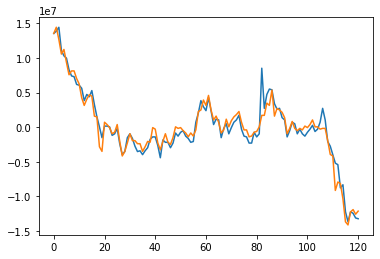

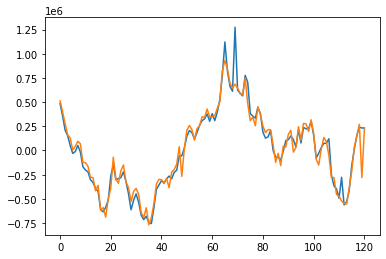

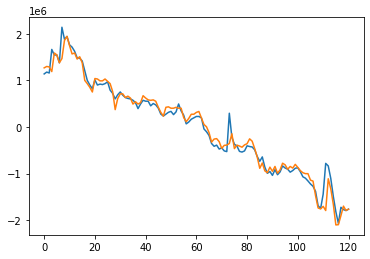

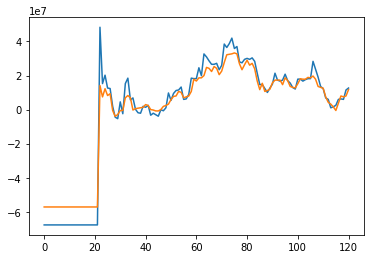

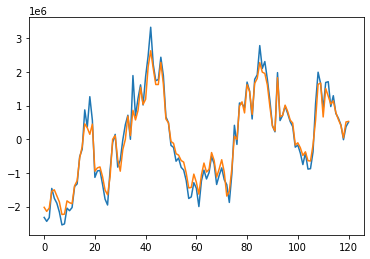

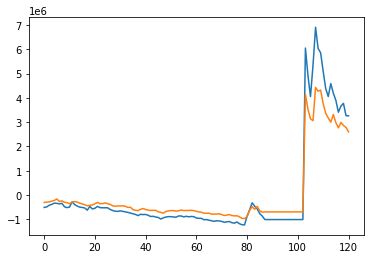

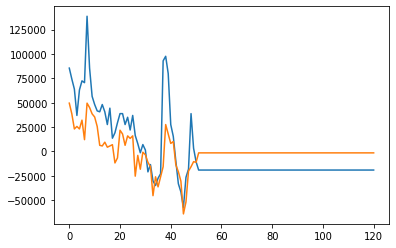

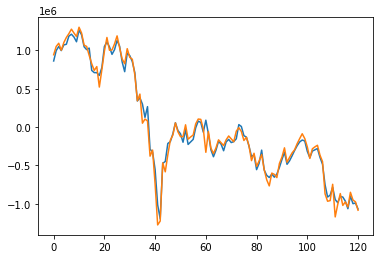

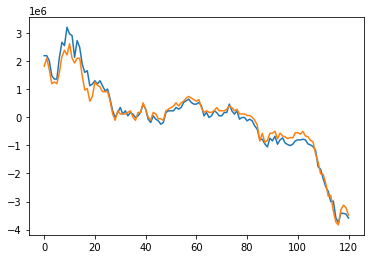

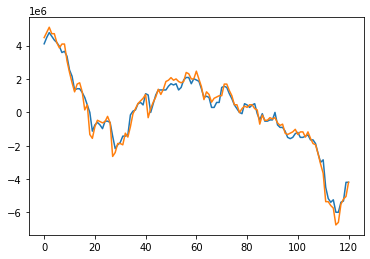

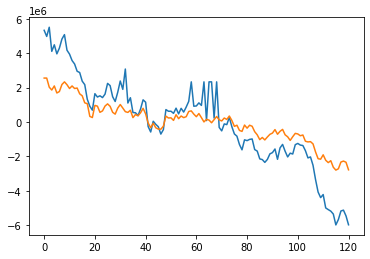

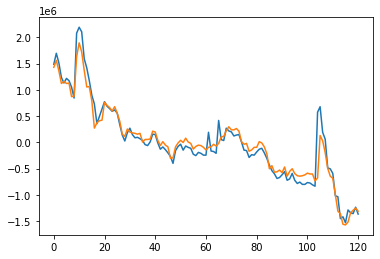

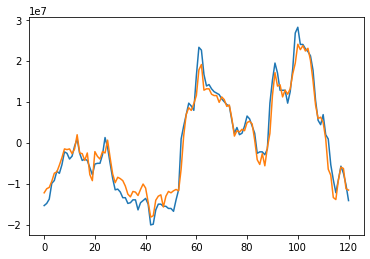

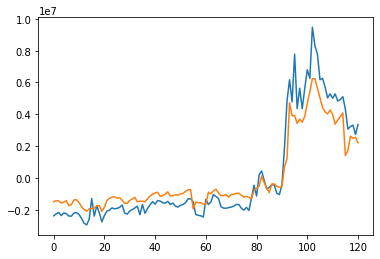

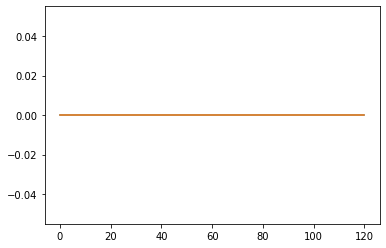

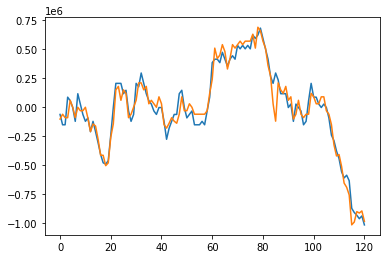

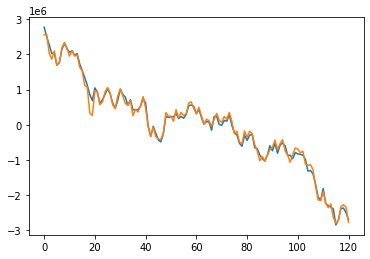

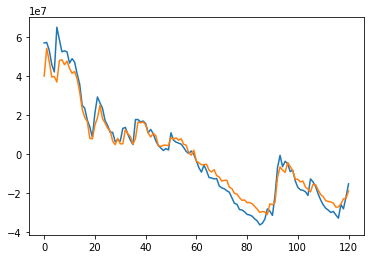

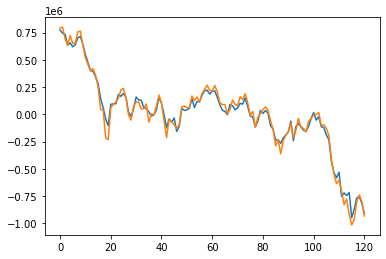

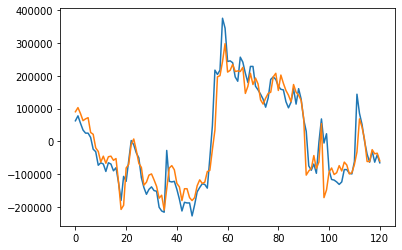

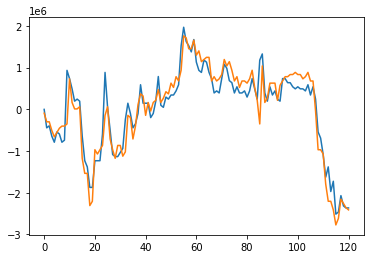

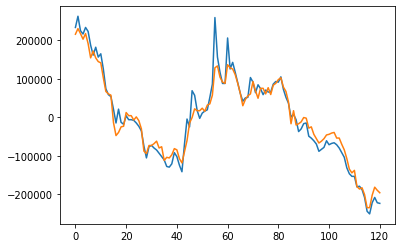

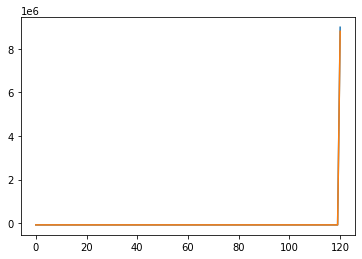

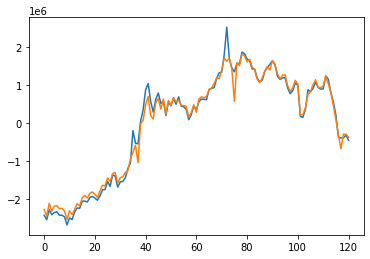

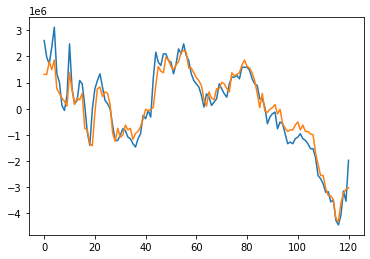

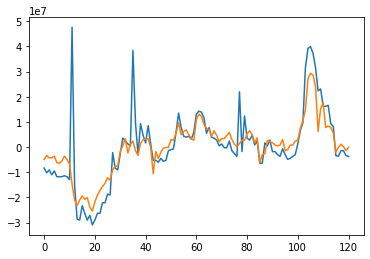

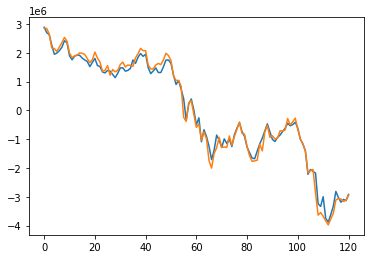

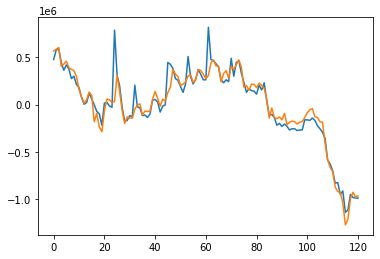

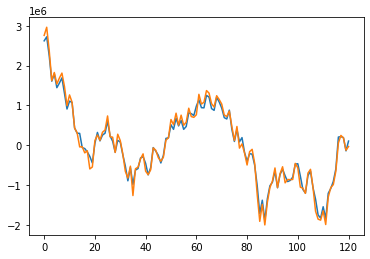

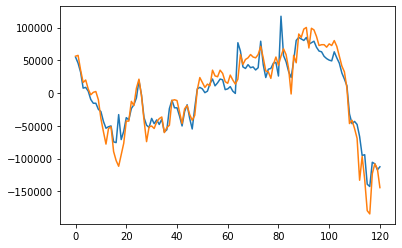

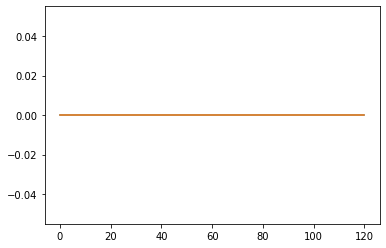

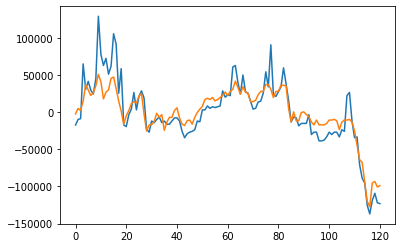

In [125]:
import matplotlib.pyplot as plt

x = np.arange(121)
for source, target in train_loader_HL:
    source, target = source.float().unsqueeze(1).to(device), target.float().unsqueeze(1).to(device)

    _, logits = model(source, target)   # logits , shape (256, 256)
    logits = logits.softmax(dim = -1)

    _, idx = torch.max(logits, dim = -1)
    
    for i in range(BATCH_SIZE):
        s = source[i]
        t = target[idx[i]]
        s = s.squeeze(0).cpu()
        t = t.squeeze(0).cpu()


        plt.plot(x, s, label = "source")
        plt.plot(x, t, label = "target")
        plt.show()

    break



